In [2]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import numpy as np
from numpy import median
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

sets the conditions of the tube

In [3]:
inputs = [

    # 1,9,17  Wt:W    
    # 2,10,18 Lux:W   
    # 3,11,19 Las:W   
    # 4,12,20 Tra:W   
    # 5,13,21 LuxR:LasI
    # 6,14,22 LuxR:LuxI
    # 7,15,23 LasR:LasI
    # 8,16,24 TraR:TraI


    
    ["LuxR_LuxI_Tube_001.fcs",'WT','none','1'],
    
    
    ["Coculture 24h_Tube"+"_004"+".fcs",'TraR','W-24','1'],
    ["Coculture 24h_Tube"+"_012"+".fcs",'TraR','W-24','2'],
    ["Coculture 24h_Tube"+"_020"+".fcs",'TraR','W-24','3'],
    
    ["Coculture 24h_Tube"+"_008"+".fcs",'TraR','TraI-24','1'],
    ["Coculture 24h_Tube"+"_016"+".fcs",'TraR','TraI-24','2'],
    ["Coculture 24h_Tube"+"_024"+".fcs",'TraR','TraI-24','3'],
    
    ["Coculture 48h_Tube"+"_004"+".fcs",'TraR','W-48','1'],
    ["Coculture 48h_Tube"+"_012"+".fcs",'TraR','W-48','2'],
    ["Coculture 48h_Tube"+"_020"+".fcs",'TraR','W-48','3'],
    
    ["Coculture 48h_Tube"+"_008"+".fcs",'TraR','TraI-48','1'],
    ["Coculture 48h_Tube"+"_016"+".fcs",'TraR','TraI-48','2'],
    ["Coculture 48h_Tube"+"_024"+".fcs",'TraR','TraI-48','3'],
    
    
    
    
    


]

       
       
tubes = []
for filename, Rprotein, Iprotein, hours,REP in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'Rprotein' : Rprotein, 'Iprotein' : Iprotein, 'Hours' : hours, 'REP' : REP }))
    
ex = flow.ImportOp(conditions = {'Rprotein' : 'str', 'Iprotein' : 'str', 'Hours' : 'float','REP' : 'float'},
                   tubes = tubes).apply()
    
       


In [4]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


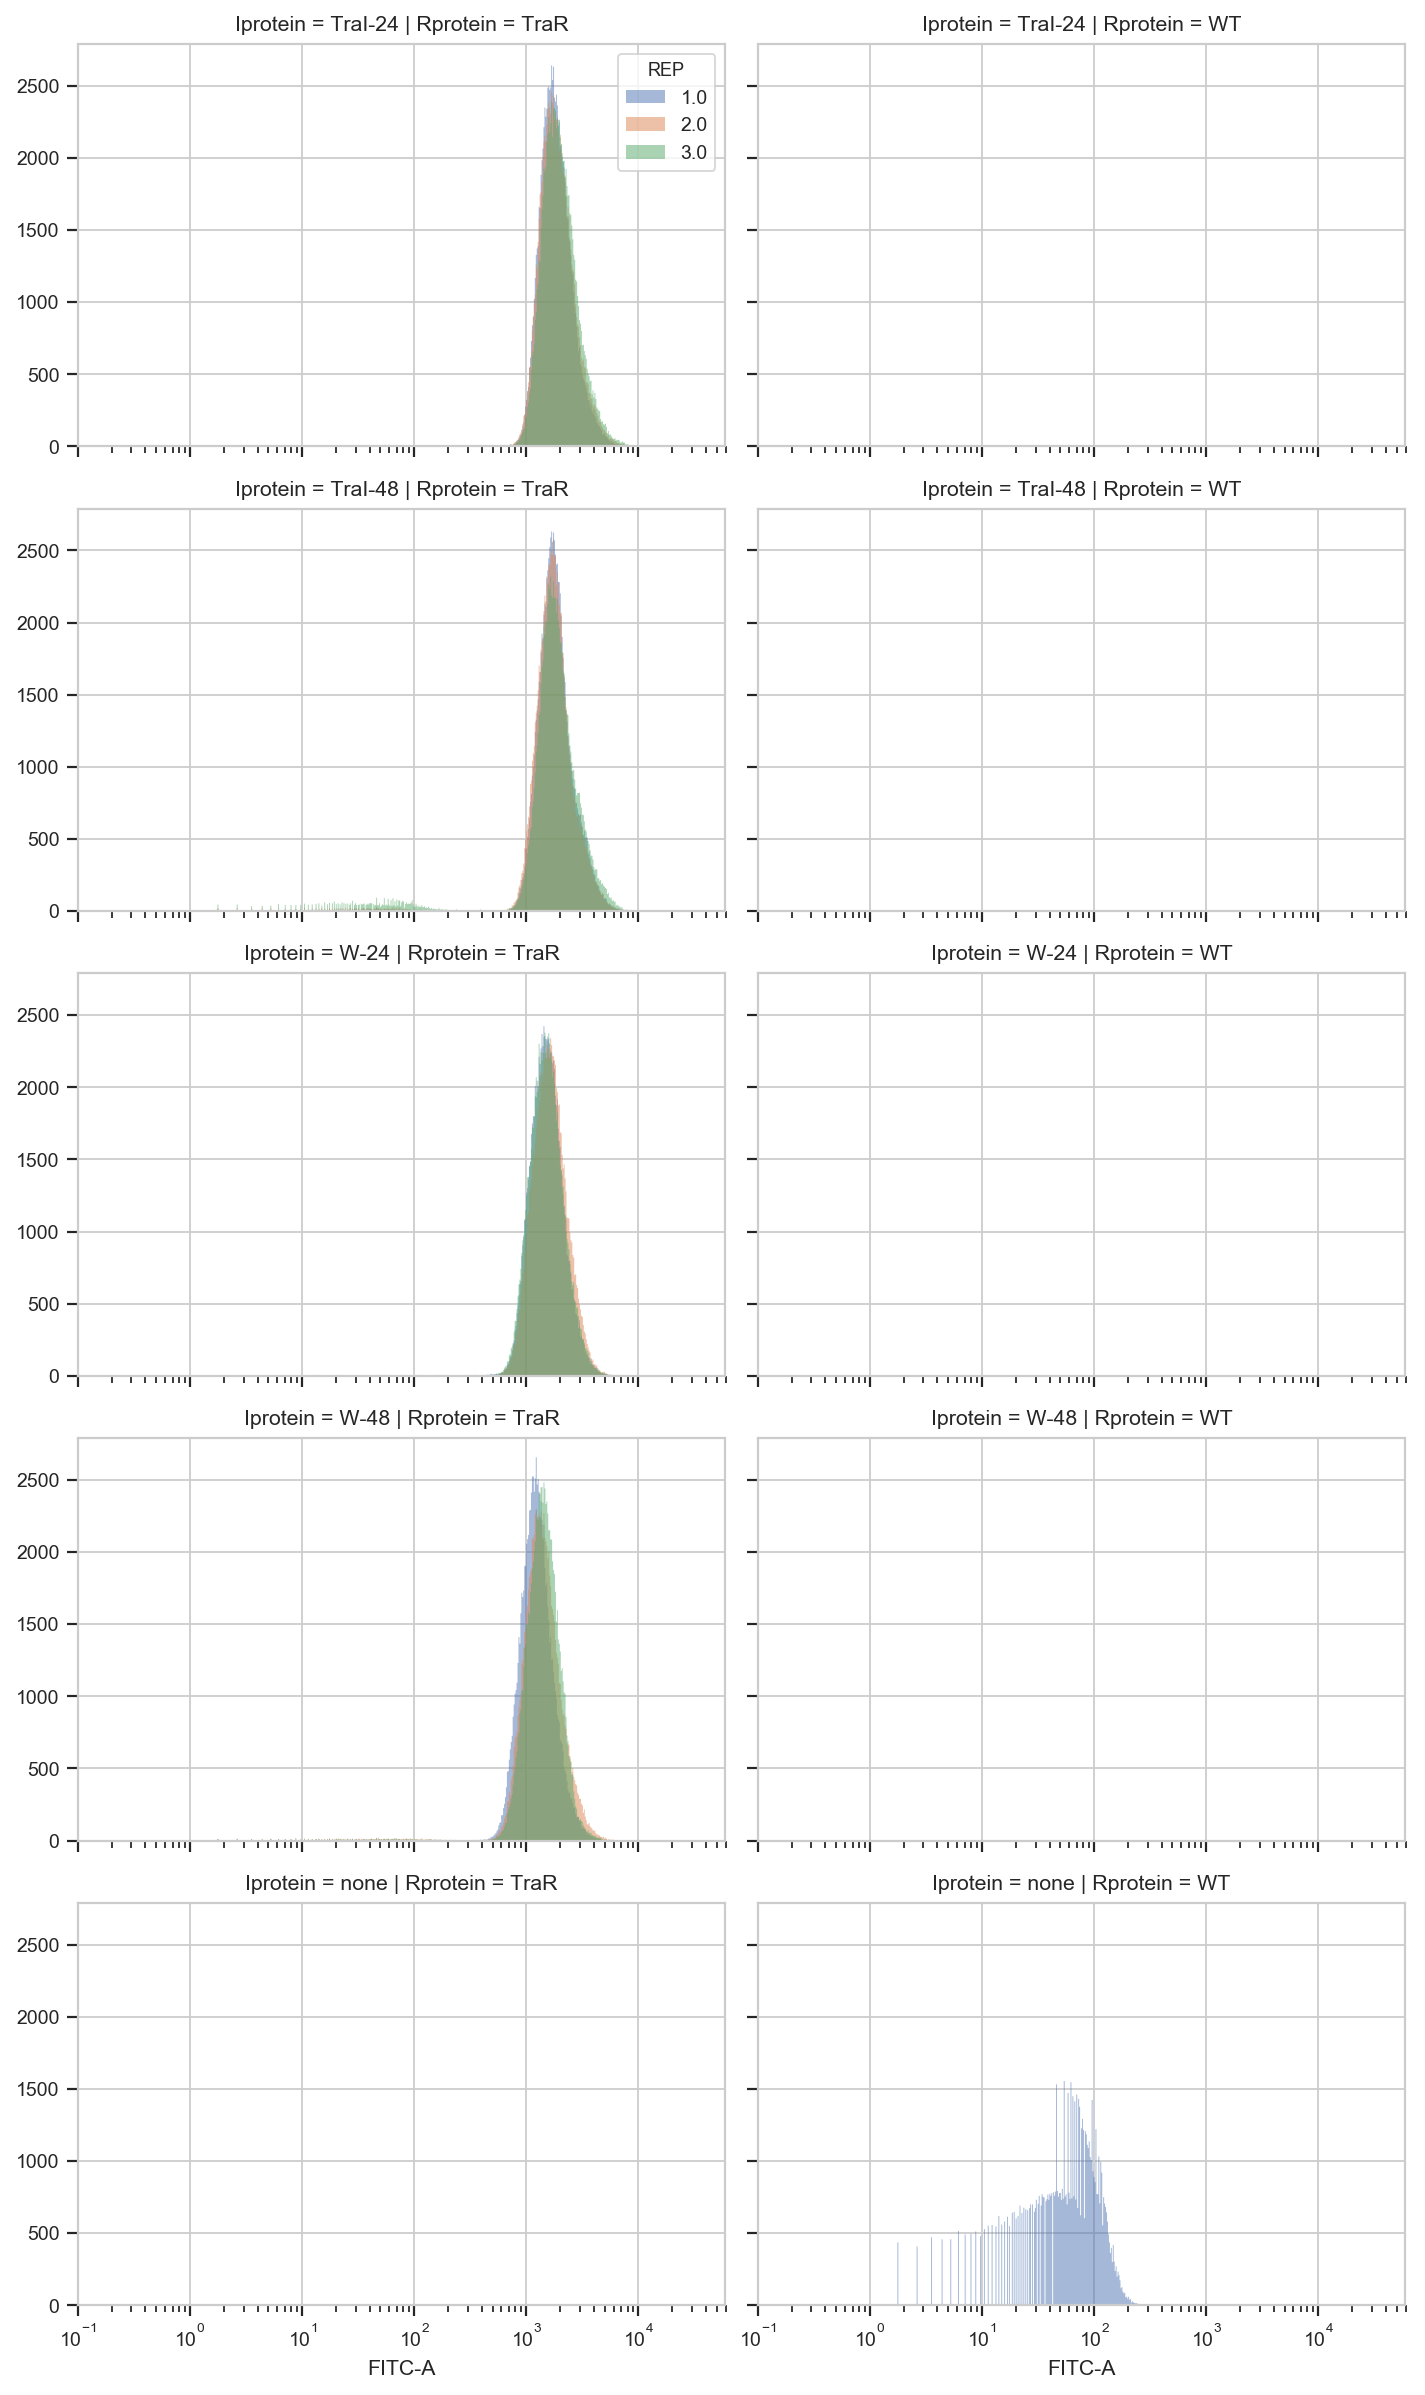

In [5]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = 'Rprotein',
                  yfacet = 'Iprotein',
                  huefacet = 'REP').plot(ex)


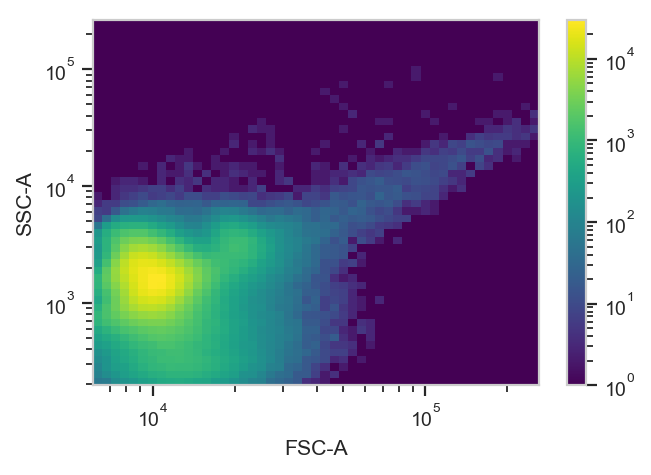

In [6]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

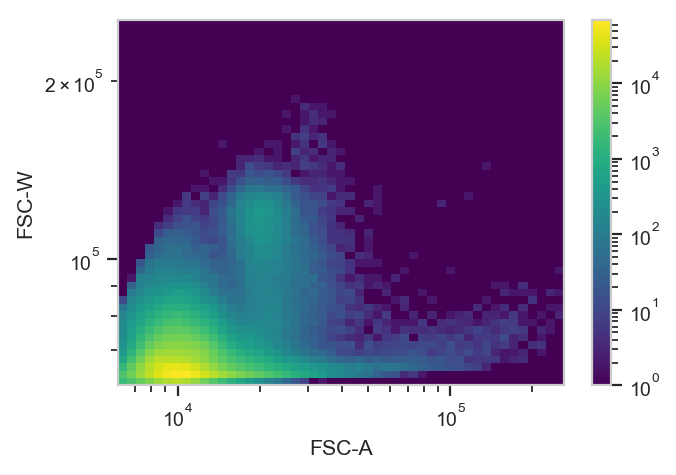

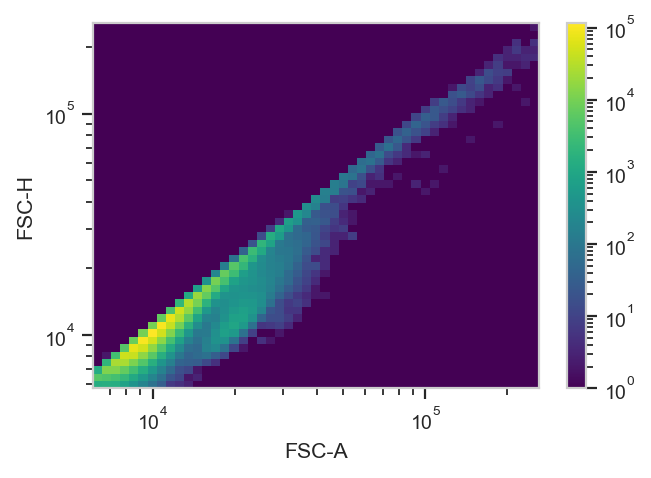

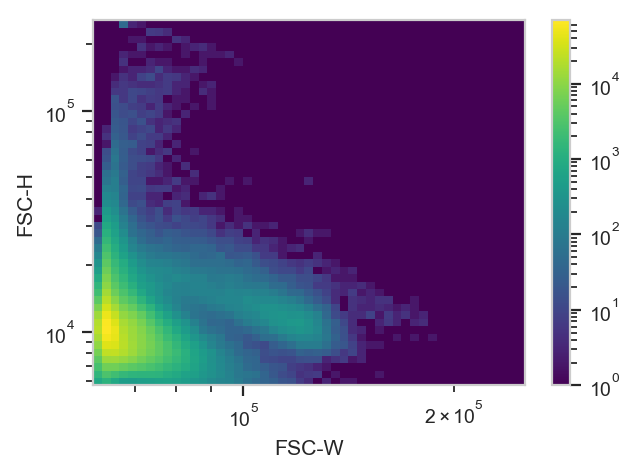

In [7]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


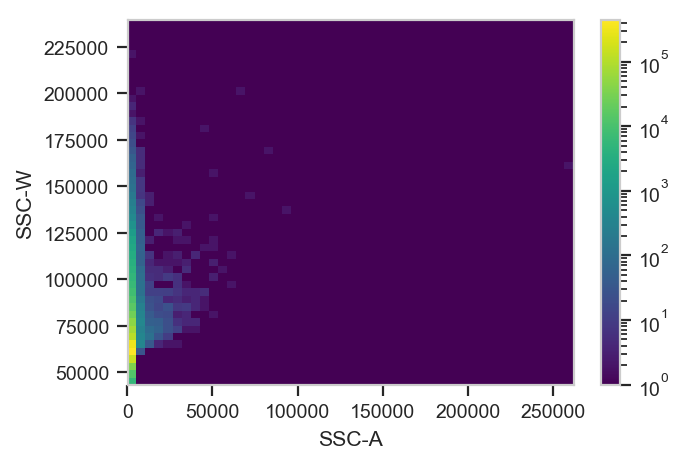

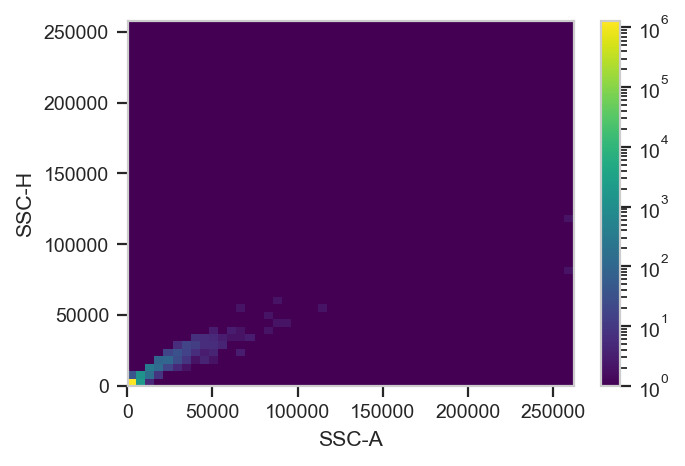

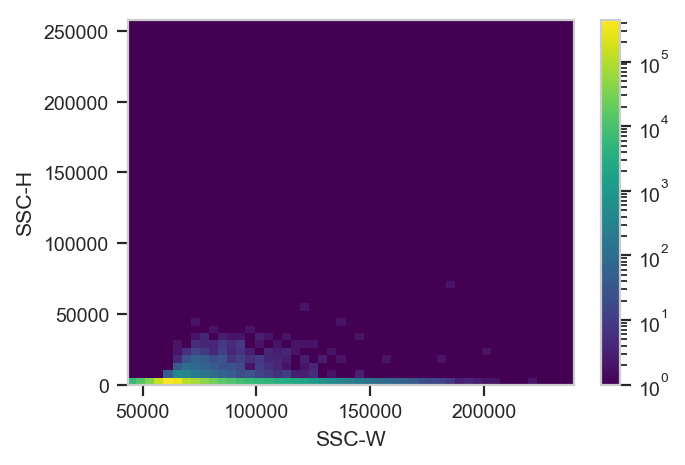

In [8]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

saves the single data as ex2

In [9]:
Chlorophyl = flow.Range2DOp(name = "Chlorophyl",
                   xchannel = "PerCP-Cy5-5-A",
                   xlow = 2000,
                   xhigh = 90000,
                   ychannel = "SSC-A",
                   ylow = 100,
                   yhigh = 15000)
                   
Chlorophylv = Chlorophyl.default_view(xscale ='log',yscale='log')

ex = Chlorophyl.apply(ex)
ex.data.groupby('Chlorophyl').size()

Chlorophyl
False       6046
True     1293954
dtype: int64

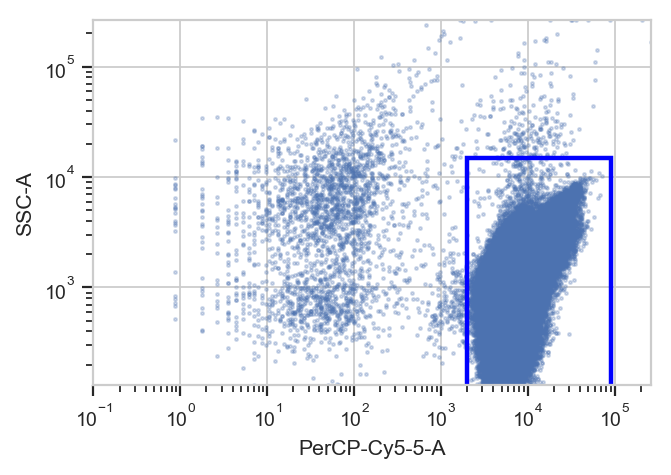

In [10]:
Chlorophylv.plot(ex)

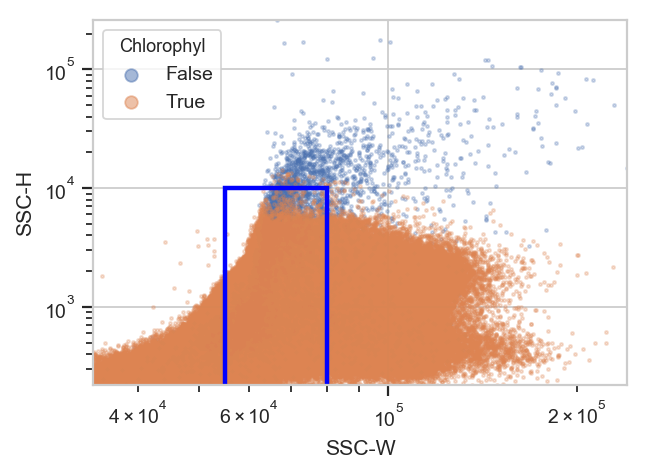

In [11]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 80000,
                   ychannel = "SSC-H",
                   ylow = 100,
                   yhigh = 10000)
                   
rv = r.default_view(xscale ='log',yscale='log',huefacet = 'Chlorophyl')

rv.plot(ex)
ex = r.apply(ex)

In [12]:
ex.data.groupby('Range2D').size()

Range2D
False     147787
True     1152213
dtype: int64

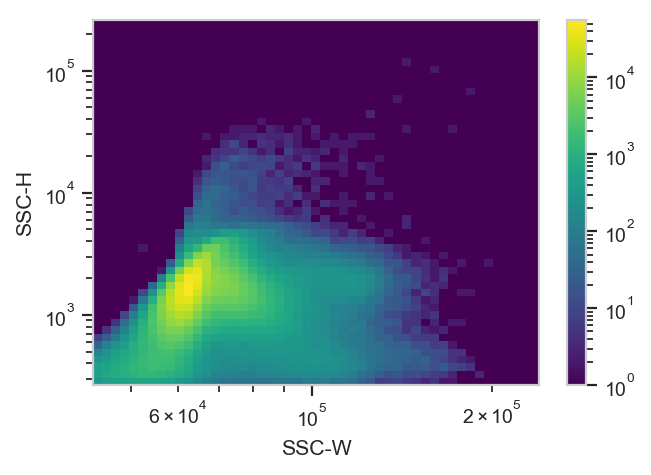

In [13]:
flow.DensityView(xchannel = "SSC-W", 
                 ychannel = "SSC-H",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


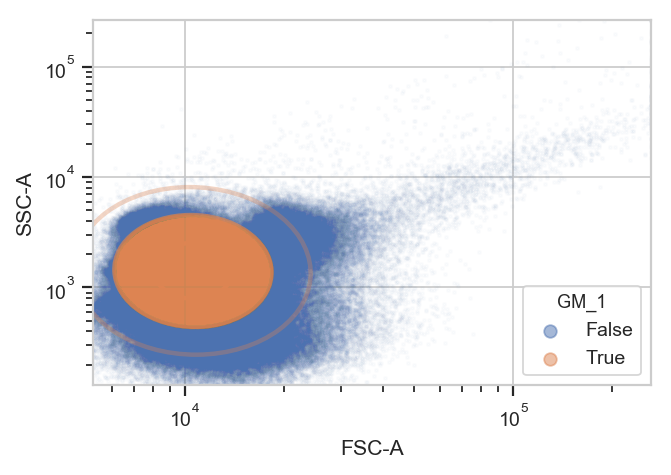

In [14]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex)
ex = gm.apply(ex)
gm.default_view().plot(ex, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


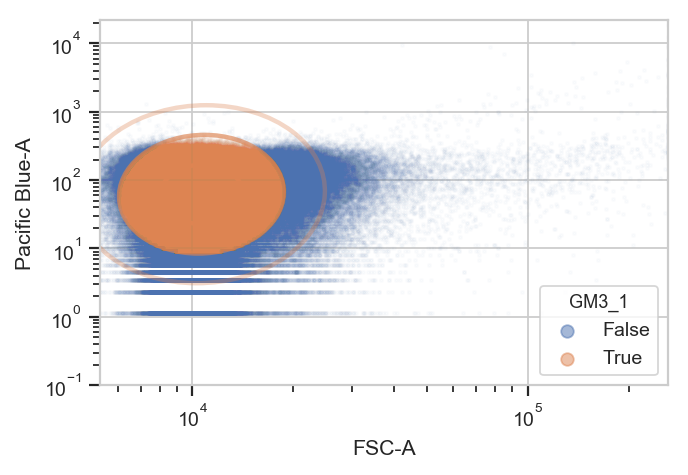

In [15]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex)
ex = gm3.apply(ex)
gm3.default_view().plot(ex, alpha = 0.02)

In [16]:
df =ex.data

In [17]:
ex.data.head()

,AmCyan-A,AmCyan-H,AmCyan-W,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,Iprotein,...,REP,Rprotein,SSC-A,SSC-H,SSC-W,Time,Chlorophyl,Range2D,GM_1,GM3_1
0,23.940001,91.0,17241.011719,-1.760000,92.0,0.000000,10310.520508,10552.0,64036.226562,none,...,1.0,WT,1342.000000,1452.0,60571.152344,52.500000,True,True,True,False
1,36.480000,118.0,20260.621094,70.400002,55.0,83886.085938,11392.379883,11610.0,64307.582031,none,...,1.0,WT,1846.239990,1872.0,64634.179688,52.599998,True,True,True,True
2,-96.900002,54.0,0.000000,101.199997,37.0,179249.796875,9765.209961,10033.0,63786.785156,none,...,1.0,WT,1520.640015,1602.0,62207.656250,52.599998,True,True,True,False
3,50.160000,58.0,56677.343750,48.400002,90.0,35243.804688,7499.290039,7742.0,63481.457031,none,...,1.0,WT,1004.960022,1098.0,59982.750000,52.599998,True,True,True,False
4,55.860001,93.0,39363.882812,51.919998,112.0,30380.615234,10060.860352,10372.0,63570.050781,none,...,1.0,WT,1283.920044,1376.0,61150.425781,52.599998,True,True,True,False


take the stuff from cytoflow and changing it to datatframe

# filter out events that don't fall within the gates

In [18]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df.Chlorophyl==True) & (df['FITC-A'] >0)] 
#df
# 

In [19]:
#f, ax = plt.subplots()
#sns.kdeplot(x='SSC-W',y='SSC-H',data=df[['SSC-W', 'SSC-H']],ax=ax)

In [20]:
df.columns 



Index(['AmCyan-A', 'AmCyan-H', 'AmCyan-W', 'FITC-A', 'FITC-H', 'FITC-W',
       'FSC-A', 'FSC-H', 'FSC-W', 'Iprotein', 'Pacific Blue-A',
       'Pacific Blue-H', 'Pacific Blue-W', 'PerCP-Cy5-5-A', 'PerCP-Cy5-5-H',
       'PerCP-Cy5-5-W', 'REP', 'Rprotein', 'SSC-A', 'SSC-H', 'SSC-W', 'Time',
       'Chlorophyl', 'Range2D', 'GM_1', 'GM3_1'],
      dtype='object')

In [21]:
data = df[['FITC-A','Rprotein','Iprotein','REP']]
#data.insert(4,'Replicate',2)
#data.to_pickle('../compiled-data/se/lux/LuxSE_2.pkl')
#uncomment these when you are ready to save replicates and compile replicate from other runs
#data['FITC-A']
#data[data.Iprotein=='W-24']['FITC-A'].median()
#data[data.Iprotein=='W-48']['FITC-A'].median()
#data[data.Iprotein=='LuxI-48']['FITC-A']#-data[data.Iprotein=='W-48']['FITC-A'].median()

In [22]:
#data[data.Iprotein=='LuxI-48']['FITC-A']-data[data.Iprotein=='W-48']['FITC-A'].median()

In [23]:
# Subtract WT background from samples
data = df[['FITC-A','Rprotein','Iprotein','REP']]
data['FITC-A'] = data['FITC-A'] - data[data.Rprotein=='WT']['FITC-A'].median()
data['FITC-A'] = data[data['FITC-A'] > 0]['FITC-A']
#data = data[data.Family=='Lux_rep1']
#data.drop('Family',inplace=True,axis=1)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
data['FITC-A'].min()

0.8800010681152344

In [25]:
data

,FITC-A,Rprotein,Iprotein,REP
1,10.560001,WT,none,1.0
11,7.920002,WT,none,1.0
12,20.240002,WT,none,1.0
13,NaN,WT,none,1.0
14,NaN,WT,none,1.0
15,16.719997,WT,none,1.0
17,29.039997,WT,none,1.0
18,NaN,WT,none,1.0
19,51.039997,WT,none,1.0
20,NaN,WT,none,1.0


# Plot median FITC-A

use median or geometeric mean 

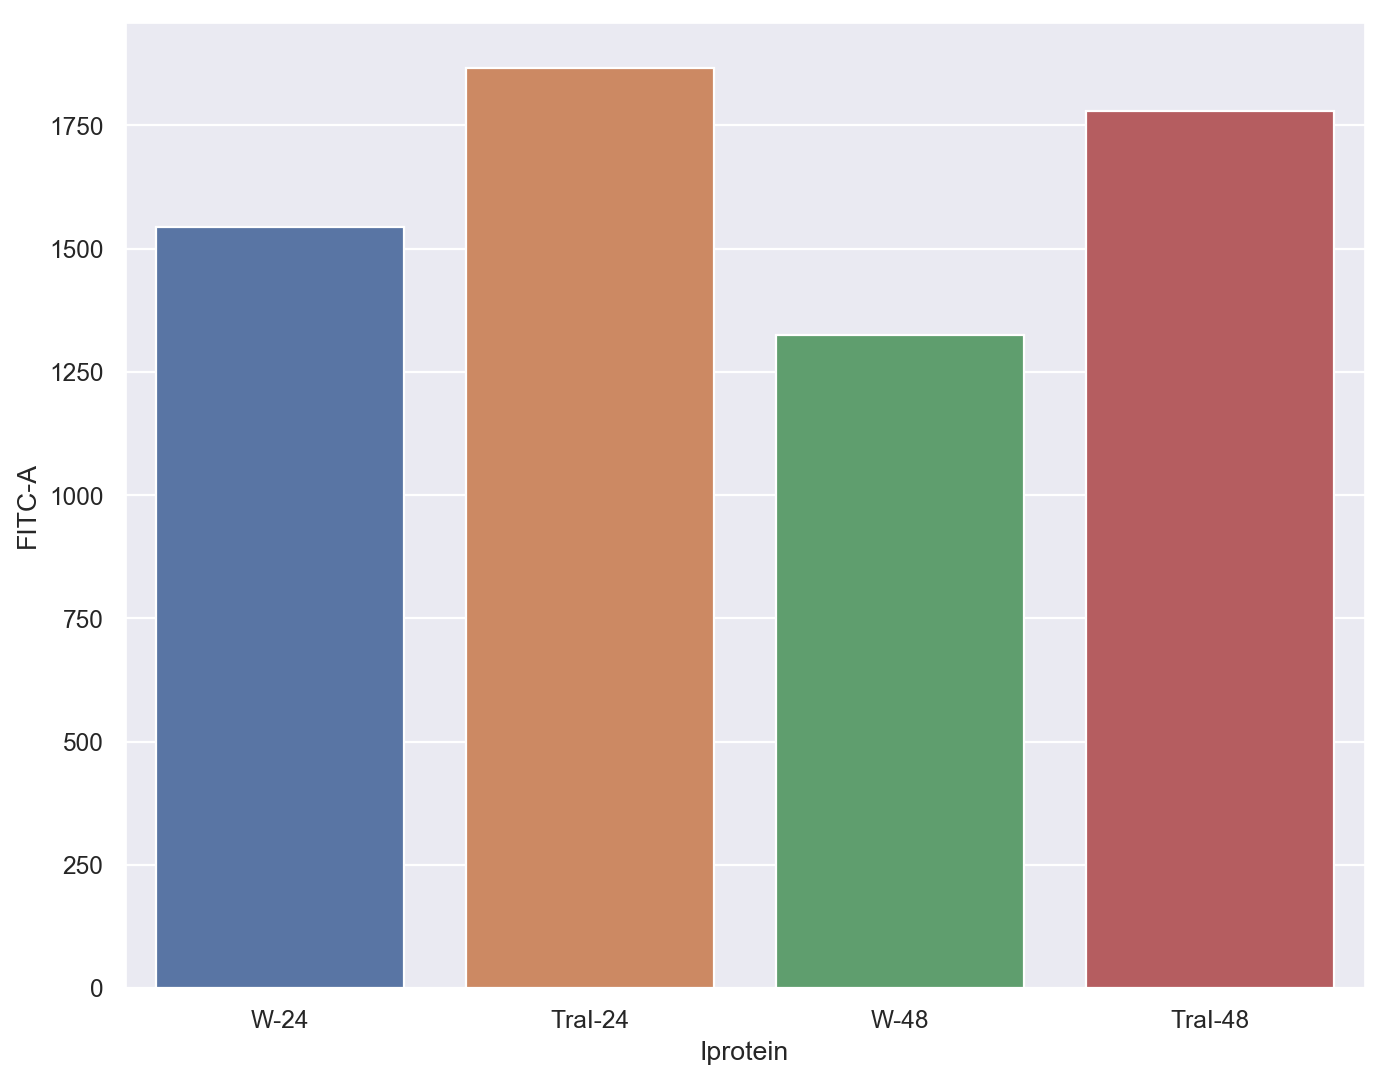

In [26]:
mfi = data.groupby(['Rprotein','Iprotein'])['FITC-A'].median().reset_index()
sns.set(font_scale=1.0)
f, ax = plt.subplots(figsize=(10,8))

#sns.pointplot(x='Rprotein',y='FITC-A',hue='Iprotein',data=mfi)
sns.barplot(x='Iprotein',y='FITC-A',data=mfi,order=['W-24','TraI-24','W-48','TraI-48'],ci=85)

#f.savefig('TraR*.png',dpi=600)
f.savefig('TraR_TraI_coculture.png',dpi=600, transparent=True)

STOP HERE